# Ernesto Antonio Reyes Ramírez
# Antonio Daniel Reyes Ramírez

# Proyecto Final: Optimización
# CIMAT

In [1]:
# importamos las librerías necesarias
import pycutest
from argparse import Namespace
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

### Funciones elementales para ambos métodos de optimización

In [2]:
# mu_k que corresponde a la ecuación (2) en el reporte
def calculate_mu(f_prev, f_curr, g_curr,s_prev, y_prev):
    muk = np.abs(2*(f_prev - f_curr + np.dot(g_curr,s_prev)/np.dot(s_prev,y_prev)) - 1)
    return muk

In [3]:
# tamaños de paso alpha_BB1 y alpha_BB2 que son mencionados en la introducción del reporte
def alpha_B1(s_prev,y_prev):
    return LA.norm(s_prev)**2/(np.dot(s_prev,y_prev))


def alpha_B2(s_prev,y_prev):
    return (np.dot(s_prev,y_prev))/LA.norm(y_prev)**2

In [4]:
# calculo del tamaño de paso alpha_AOS(2) que corresponde a la ecuación (11) en el reporte
def alpha_AOS2(g_k,B_k):
    return np.dot(g_k,g_k)/np.dot(g_k, B_k@g_k)

def alpha_AOS2_aprox(g_prev,g_curr,s_prev,B_k):
    return np.max([np.min([alpha_AOS2(g_curr,B_k), alpha_B1(s_prev,g_curr-g_prev)]), alpha_B2(s_prev,g_curr-g_prev)])

In [5]:
# cálculo del tamaño de paso alpha_AOS(11) correspondiente a la ecuación (6) en el reporte
def alpha_AOS11(g_k,B_k,sigma_k):
    delta = np.dot(g_k, B_k@g_k)**2 + 4*sigma_k*LA.norm(g_k)**5
    return (2*LA.norm(g_k)**2)/(np.sqrt(delta) + np.dot(g_k, B_k@g_k))


def alpha_AOS11_aprox(g_prev,g_curr,s_prev,B_k,sigma_k):
    return np.max([np.min([alpha_AOS11(g_curr,B_k,sigma_k), alpha_B1(s_prev,g_curr-g_prev)]), alpha_B2(s_prev,g_curr-g_prev)])

In [6]:
# cálculo del tamaño de paso alpha_AOS(31) correspondiente a la ecuación (15) en el reporte
def alpha_AOS31(g_curr,alpha_prev,s_prev,y_prev,sigma_curr):
    return (2*(LA.norm(g_curr)**2)*alpha_prev**2)/(np.sqrt(np.abs(np.dot(s_prev, y_prev))**2 + 4*(alpha_prev**4)*sigma_curr*LA.norm(g_curr)**5) + np.abs(np.dot(s_prev, y_prev)))

In [7]:
# cálculo del tamaño de paso alpha_AOS(32) correspondiente a la ecuación (16) en el reporte
def alpha_AOS4(eps,alpha_prev):
    return eps*alpha_prev

In [8]:
# función para actualizar el tamaño de paso alpha correspondiente a la ecuación (22) en el reporte
def update_alpha(alpha_hat,alpha,alphak_0):
    if alpha > 0.1*alphak_0 and 0.1*alphak_0 < alpha_hat < 0.9*alpha:
        return alpha_hat
    else:
        return 0.5*alpha

In [9]:
# cálculo del valor r_hat que se utiliza para calcular el regularizador de la ecuación (10) en el reporte
def r_hat(s_prev,y_prev,B):
    return 3*(np.dot(s_prev, y_prev) - np.dot(s_prev, B@s_prev))


def r_hat_aprox(s_prev,y_prev,B,xi1):
    return np.min([np.max([r_hat(s_prev,y_prev,B),-xi1*np.dot(s_prev, y_prev)]),xi1*np.dot(s_prev, y_prev)])

In [10]:
# cálculo del regularizador sigma1 correspondiente a la ecuación (10) en el reporte
def sigma1(p,f_prev,f_curr,g_curr,s_prev,y_prev,B,xi1):
    r = r_hat_aprox(s_prev,y_prev,B,xi1)
    return (p*(f_prev - f_curr + np.dot(g_curr, s_prev) - 0.5*(np.dot(s_prev, y_prev) + r)))/(LA.norm(s_prev)**p)


def sigma1_aprox(p,f_prev,f_curr,g_curr,s_prev,y_prev,B,xi1,sigmax,sigmin):
    sigma = sigma1(p,f_prev,f_curr,g_curr,s_prev,y_prev,B,xi1)
    return np.max([np.min([np.abs(sigma),sigmax]),sigmin])

In [11]:
# cálculo del regularizador sigma3 correspondiente a la ecuación (17) en el reporte
def sigma3(p,f_prev,f_curr,g_curr,s_prev,y_prev):
    return (p*(f_prev - f_curr + np.dot(g_curr, s_prev) - 0.5*(np.dot(s_prev, y_prev))))/(LA.norm(s_prev)**p)


def sigma3_aprox(p,f_prev,f_curr,g_curr,s_prev,y_prev,sigmax,sigmin):
    sigma = sigma3(p,f_prev,f_curr,g_curr,s_prev,y_prev)
    return np.max([np.min([np.abs(sigma),sigmax]),sigmin])

In [12]:
# cálculo del tamaño de paso alpha_AOS(32) correspondiente a la ecuación (16) en el reporte
def alpha_AOS32(gk,sigmak,y_prev,s_prev,alpha_prev):
    delta = (1.0)/(4*(sigmak**2)*LA.norm(gk)**4) + np.abs(np.dot(s_prev,y_prev))**3/(27*(sigmak**3)*(alpha_prev*6)*LA.norm(gk)**12)
    return np.cbrt((1.0)/(2*sigmak*LA.norm(gk)**2) + np.sqrt(delta) ) + np.cbrt((1.0)/(2*sigmak*LA.norm(gk)**2) - np.sqrt(delta) )


def alpha_AOS32_aprox(g_curr,sigmak,s_prev,y_prev,alpha_prev):
    return np.max([np.min([alpha_AOS32(g_curr,sigmak,y_prev,s_prev,alpha_prev),alpha_B1(s_prev,y_prev)]),alpha_B2(s_prev,y_prev)])

In [13]:
# cálculo del tamaño de paso alpha_AOS(12) correpondiente a la ecuación (9) en el reporte
def alpha_AOS12(gk,sigmak,Bk):
    delta = (1.0)/(4*sigmak*LA.norm(gk)) + (np.dot(gk,Bk@gk))**3/(27*sigmak*LA.norm(gk)**2)
    return np.cbrt((1.0)/(2*sigmak*LA.norm(gk)**2) + np.sqrt(delta) ) + np.cbrt((1.0)/(2*sigmak*LA.norm(gk)**2) - np.sqrt(delta) )


def alpha_AOS12_aprox(g_curr,B_curr,sigmak,s_prev,y_prev):
    return np.max([np.min([alpha_AOS12(g_curr,sigmak,B_curr),alpha_B1(s_prev,y_prev)]),alpha_B2(s_prev,y_prev)])

### Dos métodos de optimización con tamaños de paso aproximadamente óptimos

In [14]:
# función para calcular el tamaño de paso aproximadamente óptimo con p = 3
def GM_AOS3(epsilon,delta,c,c1,c2,alphaMax,alphaMin,alpha0_0,sigmaMin,sigmaMax,
           xi0,xi1,xi2,xi3,p, MAX):
    gradients = [] # arreglo donde guardaremos los valores del gradiente

    k = 0
    Qk = 1
    x0 = p.x0
    n = p.n
    f_curr,g_curr = p.obj(x0, gradient = True)
    d_curr = g_curr
    Ck = f_curr
    x_curr = x0
    alphak_0 = alpha0_0
    gradients.append(d_curr)

    for k in range(MAX):
    #paso 1
        if LA.norm(d_curr, ord = np.inf) <= epsilon:
            break
    #paso 2
        if k == 0:
            alpha = alphak_0
            mu_curr = -np.inf
        else:
            s_prev = x_curr - x_prev
            y_prev = g_curr - g_prev
            cond1 = np.dot(s_prev,y_prev)
            mu_curr = calculate_mu(f_prev,f_curr,g_curr,s_prev,y_prev)
            B_curr = p.hess(x_curr)

            if cond1 > 0:
            # paso 2.3
                if mu_curr <= c1 or np.max([mu_curr,mu_prev])<= c2:
                    alpha = alpha_AOS2_aprox(g_prev,g_curr,s_prev,B_curr)
            #paso 2.2
                else:
                    B_aux = p.hess(x_prev + mu_curr*s_prev) # Verificar con otros valores de mu
                    sigma_curr = sigma1_aprox(3,f_prev,f_curr,g_curr,s_prev,y_prev,B_aux,xi1,sigmaMax,sigmaMin) #Cambiar por 3 y 4 dependiendo
                    alpha = alpha_AOS11_aprox(g_prev,g_curr,s_prev,B_curr,sigma_curr)
            else:
            # paso 2.4
                cond2 = LA.norm(g_prev)**2/LA.norm(g_curr)**2
                if cond2 >= xi2:
                    sigma_curr = sigma3_aprox(3,f_prev,f_curr,g_curr,s_prev,y_prev,sigmaMax,sigmaMin) #3o 4
                    alpha = alpha_AOS31(g_curr,alphak,s_prev,y_prev,sigma_curr)
            # paso 2.5
                else:
                    alpha = alpha_AOS4(xi3,alphak) 
        # paso 2.6
            alphak_0 = np.max([np.min([alphak,alphaMax]),alphaMin])
            alpha = alphak_0
        # paso 3
        f_aux = p.obj(x_curr-alpha*g_curr, gradient= False)

        for i in range(1): #experimentar
            if f_aux > Ck - delta*alpha*LA.norm(g_curr)**2: 
                alpha = 0.5*alpha
            else:
                break

        #paso 5
        x_prev = x_curr
        x_curr = x_prev - alpha*g_curr
        g_prev = g_curr
        f_prev = f_curr
        f_curr,g_curr = p.obj(x_curr, gradient = True)
        d_curr = g_curr
        g_curr = g_curr/LA.norm(g_curr, ord = np.inf)
        mu_prev = mu_curr
        gradients.append(d_curr)
        
        # paso 4
        if k%n == n-1:
            etak = c
        else:
            etak = 1

        Qk = etak*Qk + 1
        Ck = (etak*Qk*Ck + f_curr )/Qk

        alphak = alpha 

    
    return x_curr, g_curr, k, gradients

In [15]:
# función para calcular el tamaño de paso aproximadamente óptimo con p = 4
def GM_AOS4(epsilon,delta,c,c1,c2,alphaMax,alphaMin,alpha0_0,sigmaMin,sigmaMax,
           xi0,xi1,xi2,xi3,p, MAX):
    gradients = [] # arreglo donde guardaremos los valores del gradiente

    k = 0
    Qk = 1
    x0 = p.x0
    n = p.n
    f_curr,g_curr = p.obj(x0, gradient = True)
    d_curr = g_curr
    Ck = f_curr
    x_curr = x0
    alphak_0 = alpha0_0
    gradients.append(d_curr)

    for k in range(MAX):
    #paso 1
        if LA.norm(d_curr, ord = np.inf) <= epsilon:
            break
    #paso 2
        if k == 0:
            alpha = alphak_0
            mu_curr = -np.inf
        else:
            s_prev = x_curr - x_prev
            y_prev = g_curr - g_prev
            cond1 = np.dot(s_prev,y_prev)
            mu_curr = calculate_mu(f_prev,f_curr,g_curr,s_prev,y_prev)
            B_curr = p.hess(x_curr)

            if cond1 > 0:
            # paso 2.3
                if mu_curr <= c1 or np.max([mu_curr,mu_prev])<= c2:
                    alpha = alpha_AOS2_aprox(g_prev,g_curr,s_prev,B_curr)
            #paso 2.2
                else:
                    B_aux = p.hess(x_prev + mu_curr*s_prev) # Verificar con otros valores de mu
                    sigma_curr = sigma1_aprox(4,f_prev,f_curr,g_curr,s_prev,y_prev,B_aux,xi1,sigmaMax,sigmaMin) #Cambiar por 3 y 4 dependiendo
                    alpha = alpha_AOS12_aprox(g_curr,B_curr,sigma_curr,s_prev,y_prev)
            else:
            # paso 2.4
                cond2 = LA.norm(g_prev)**2/LA.norm(g_curr)**2
                if cond2 >= xi2:
                    sigma_curr = sigma3_aprox(4,f_prev,f_curr,g_curr,s_prev,y_prev,sigmaMax,sigmaMin) #3o 4
                    alpha = alpha_AOS32_aprox(g_curr,sigma_curr,s_prev,y_prev,alphak)
            # paso 2.5
                else:
                    alpha = alpha_AOS4(xi3,alphak) 
        # paso 2.6
            alphak_0 = np.max([np.min([alphak,alphaMax]),alphaMin])
            alpha = alphak_0
        # paso 3
        f_aux = p.obj(x_curr-alpha*g_curr, gradient= False)

        for i in range(1): #experimentar
            if f_aux > Ck - delta*alpha*LA.norm(g_curr)**2: 
                alpha = 0.5*alpha
            else:
                break

        #paso 5
        x_prev = x_curr
        x_curr = x_prev - alpha*g_curr
        g_prev = g_curr
        f_prev = f_curr
        f_curr,g_curr = p.obj(x_curr, gradient = True)
        d_curr = g_curr
        g_curr = g_curr/LA.norm(g_curr, ord = np.inf)
        mu_prev = mu_curr
        gradients.append(d_curr)
        
        # paso 4
        if k%n == n-1:
            etak = c
        else:
            etak = 1

        Qk = etak*Qk + 1
        Ck = (etak*Qk*Ck + f_curr )/Qk

        alphak = alpha 

    
    return x_curr, g_curr, k, gradients

## Pruebas del método con p = 3

**Función ROSENBR**

In [16]:
p = pycutest.import_problem('ROSENBR')
print(p)

CUTEst problem ROSENBR (default params) with 2 variables and 0 constraints


In [17]:
# función para calcular el tamaño de paso inicial alpha_0
def calculate_ini_alpha(x0,f0,g0):
    if LA.norm(x0, ord = np.inf) < 10e-30:
        if np.abs(f0) >= 10e-30:
            return 2*np.abs(f0)/LA.norm(g0, ord = np.inf)**2
        else:
            return 1
    else:
        if LA.norm(g0, ord = np.inf) >= 10e7:
            aux = np.min([1, np.max([LA.norm(x0, ord = np.inf)/LA.norm(g0, ord = np.inf),1/LA.norm(g0, ord = np.inf)])])
            return aux
        else:
            aux = np.min([1, LA.norm(x0, ord = np.inf)/LA.norm(g0, ord = np.inf)])
            return aux

In [18]:
# definimos los parámetros 
epsilon = 10e-6
delta = 10e-4
c = 0.99
MAX = 100000
c1 = 10e-9
c2 = 10e-7
alphaMax = 10e30
alphaMin = 10e-30
sigmaMin = 10e-30
sigmaMax = 10e3
xi0 = 1.07
xi1 = 5*10e-5/3
xi2 = 0.8
xi3 = 5
x0 = p.x0
f0, g0 = p.obj(x0, gradient = True)
alpha0 = calculate_ini_alpha(x0,f0,g0)

In [19]:
xk, gk, iter, gradients = GM_AOS3(epsilon,delta,c,c1,c2,alphaMax,alphaMin,alpha0,sigmaMin,sigmaMax,
           xi0,xi1,xi2,xi3,p, MAX)

In [20]:
print("Número de iteraciones: ",iter)
print("Norma final del gradiente: ", LA.norm(gradients[-1], np.inf))

Número de iteraciones:  8255
Norma final del gradiente:  9.836662173690058e-06


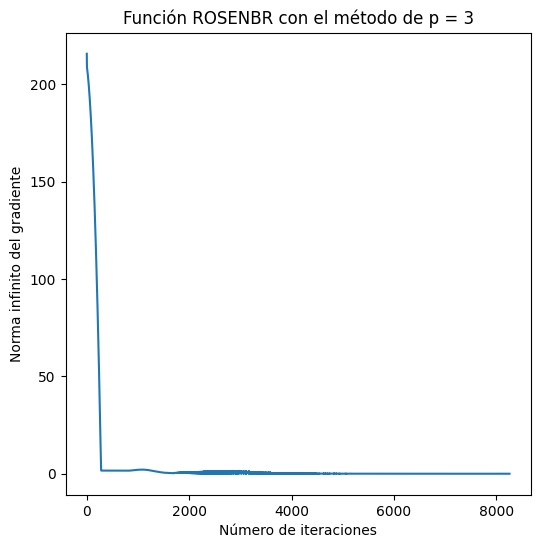

In [21]:
# vector con la norma de los gradientes
grad_norm = [LA.norm(g, ord = np.inf) for g in gradients]
z = range(len(grad_norm))

plt.figure(figsize=(6,6))
plt.plot(z,grad_norm)
plt.title("Función ROSENBR con el método de p = 3")
plt.xlabel("Número de iteraciones")
plt.ylabel("Norma infinito del gradiente")
plt.show()

**Función TOINTGSS**

In [22]:
p = pycutest.import_problem('TOINTGSS', sifParams={'N':5000})
print(p)

CUTEst problem TOINTGSS (params {'N': 5000}) with 5000 variables and 0 constraints


In [23]:
x0 = p.x0
f0, g0 = p.obj(x0, gradient = True)
alpha0 = calculate_ini_alpha(x0,f0,g0)

In [24]:
xk, gk, iter, gradients = GM_AOS3(epsilon,delta,c,c1,c2,alphaMax,alphaMin,alpha0,sigmaMin,sigmaMax,
           xi0,xi1,xi2,xi3,p, MAX)

In [25]:
print("Número de iteraciones: ",iter)
print("Norma final del gradiente: ", LA.norm(gradients[-1], np.inf))

Número de iteraciones:  1
Norma final del gradiente:  9.836762893637634e-41


**Función DENSCHNB**

In [26]:
p = pycutest.import_problem('DENSCHNB')
print(p)

CUTEst problem DENSCHNB (default params) with 2 variables and 0 constraints


In [27]:
x0 = p.x0
f0, g0 = p.obj(x0, gradient = True)
alpha0 = calculate_ini_alpha(x0,f0,g0)

In [28]:
xk, gk, iter, gradients = GM_AOS3(epsilon,delta,c,c1,c2,alphaMax,alphaMin,alpha0,sigmaMin,sigmaMax,
           xi0,xi1,xi2,xi3,p, MAX)

In [29]:
print("Número de iteraciones: ",iter)
print("Norma final del gradiente: ", LA.norm(gradients[-1], np.inf))

Número de iteraciones:  5383
Norma final del gradiente:  5.153111352632671e-06


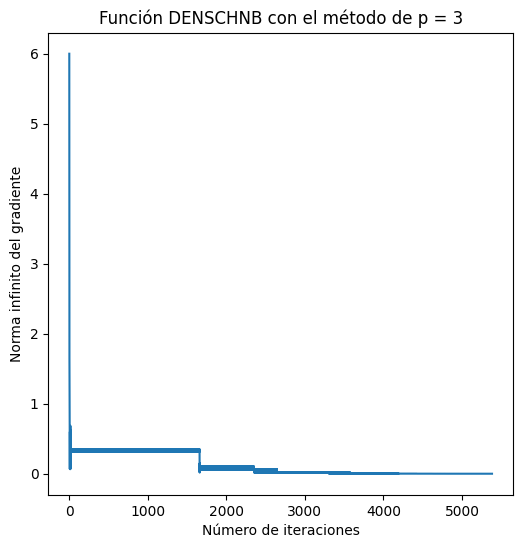

In [30]:
# vector con la norma de los gradientes
grad_norm = [LA.norm(g, ord = np.inf) for g in gradients]
z = range(len(grad_norm))

plt.figure(figsize=(6,6))
plt.plot(z,grad_norm)
plt.title("Función DENSCHNB con el método de p = 3")
plt.xlabel("Número de iteraciones")
plt.ylabel("Norma infinito del gradiente")
plt.show()

## Pruebas del método con p = 4

**Función ROSENBR**

In [31]:
p = pycutest.import_problem('ROSENBR')
print(p)

CUTEst problem ROSENBR (default params) with 2 variables and 0 constraints


In [32]:
# definimos los parámetros 
epsilon = 10e-6
delta = 10e-4
c = 0.99
MAX = 100000
c1 = 10e-9
c2 = 10e-7
alphaMax = 10e30
alphaMin = 10e-30
sigmaMin = 10e-30
sigmaMax = 10e3
xi0 = 1.07
xi1 = 5*10e-5/3
xi2 = 0.8
xi3 = 5
x0 = p.x0
f0, g0 = p.obj(x0, gradient = True)
alpha0 = calculate_ini_alpha(x0,f0,g0)

In [33]:
xk, gk, iter, gradients = GM_AOS4(epsilon,delta,c,c1,c2,alphaMax,alphaMin,alpha0,sigmaMin,sigmaMax,
           xi0,xi1,xi2,xi3,p, MAX)

In [34]:
print("Número de iteraciones: ",iter)
print("Norma final del gradiente: ", LA.norm(gradients[-1], np.inf))

Número de iteraciones:  8255
Norma final del gradiente:  9.836662173690058e-06


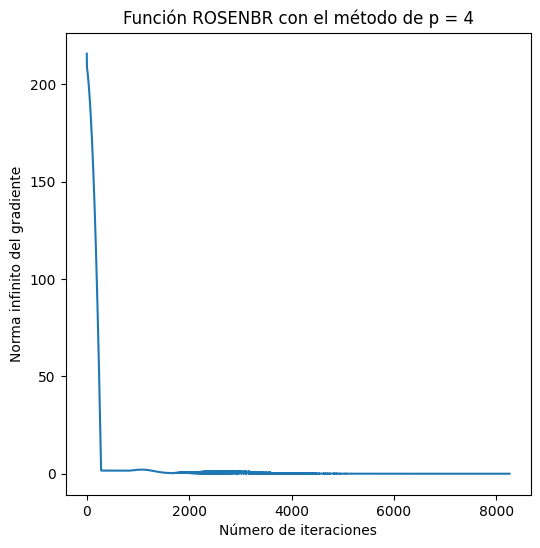

In [35]:
# vector con la norma de los gradientes
grad_norm = [LA.norm(g, ord = np.inf) for g in gradients]
z = range(len(grad_norm))

plt.figure(figsize=(6,6))
plt.plot(z,grad_norm)
plt.title("Función ROSENBR con el método de p = 4")
plt.xlabel("Número de iteraciones")
plt.ylabel("Norma infinito del gradiente")
plt.show()

**Función TOINTGSS**

In [36]:
p = pycutest.import_problem('TOINTGSS', sifParams={'N':5000})
print(p)

CUTEst problem TOINTGSS (params {'N': 5000}) with 5000 variables and 0 constraints


In [37]:
x0 = p.x0
f0, g0 = p.obj(x0, gradient = True)
alpha0 = calculate_ini_alpha(x0,f0,g0)

In [38]:
xk, gk, iter, gradients = GM_AOS4(epsilon,delta,c,c1,c2,alphaMax,alphaMin,alpha0,sigmaMin,sigmaMax,
           xi0,xi1,xi2,xi3,p, MAX)

In [39]:
print("Número de iteraciones: ",iter)
print("Norma final del gradiente: ", LA.norm(gradients[-1], np.inf))

Número de iteraciones:  1
Norma final del gradiente:  9.836762893637634e-41


**Función DENSCHNB**

In [40]:
p = pycutest.import_problem('DENSCHNB')
print(p)

CUTEst problem DENSCHNB (default params) with 2 variables and 0 constraints


In [41]:
x0 = p.x0
f0, g0 = p.obj(x0, gradient = True)
alpha0 = calculate_ini_alpha(x0,f0,g0)

In [42]:
xk, gk, iter, gradients = GM_AOS3(epsilon,delta,c,c1,c2,alphaMax,alphaMin,alpha0,sigmaMin,sigmaMax,
           xi0,xi1,xi2,xi3,p, MAX)

In [43]:
print("Número de iteraciones: ",iter)
print("Norma final del gradiente: ", LA.norm(gradients[-1], np.inf))

Número de iteraciones:  5383
Norma final del gradiente:  5.153111352632671e-06


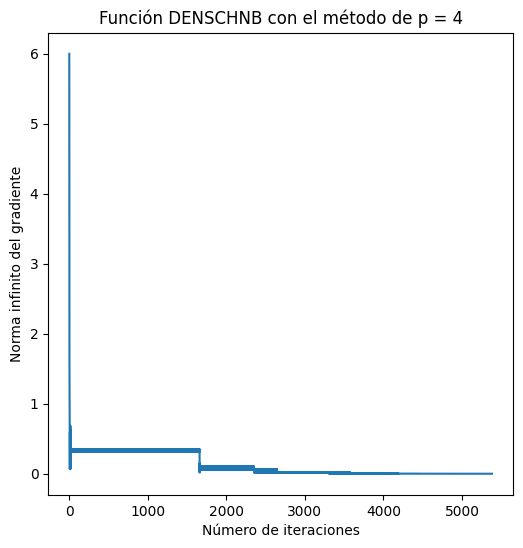

In [44]:
# vector con la norma de los gradientes
grad_norm = [LA.norm(g, ord = np.inf) for g in gradients]
z = range(len(grad_norm))

plt.figure(figsize=(6,6))
plt.plot(z,grad_norm)
plt.title("Función DENSCHNB con el método de p = 4")
plt.xlabel("Número de iteraciones")
plt.ylabel("Norma infinito del gradiente")
plt.show()